In [20]:
import pandas as pd

# Load the dataset
data = pd.read_csv('./Solar Power Plant Data.csv')

# Drop the columns that are not required
columns_to_keep = ['Date-Hour(NMT)', 'SystemProduction']
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
data = data.drop(columns_to_drop, axis=1)

# Reformatting the date column, taking only the hours
data['Date-Hour(NMT)'] = pd.to_datetime(data['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')
data['Month'] = data['Date-Hour(NMT)'].dt.month
data['Day'] = data['Date-Hour(NMT)'].dt.day
data['Hour'] = data['Date-Hour(NMT)'].dt.hour

# Removing the data points where the system production is zero
data = data[data['Hour'].between(6, 22)]
data = data[data['SystemProduction'] != 0]

data.head()

,Date-Hour(NMT),SystemProduction,Month,Day,Hour
11,2017-01-01 11:00:00,215.8333,1,1,11
12,2017-01-01 12:00:00,831.6667,1,1,12
13,2017-01-01 13:00:00,349.5000,1,1,13
14,2017-01-01 14:00:00,272.0000,1,1,14
15,2017-01-01 15:00:00,130.2083,1,1,15


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare the data for modeling
x = data[['Month', 'Day', 'Hour']]
y = data['SystemProduction']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(scaler.mean_, scaler.scale_)
# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(x_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(x_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

[ 6.51393662 16.15158457 13.93967163] [2.65563593 8.99027562 3.8395894 ]
Mean Squared Error: 1087659.22
R^2 Score: 0.72


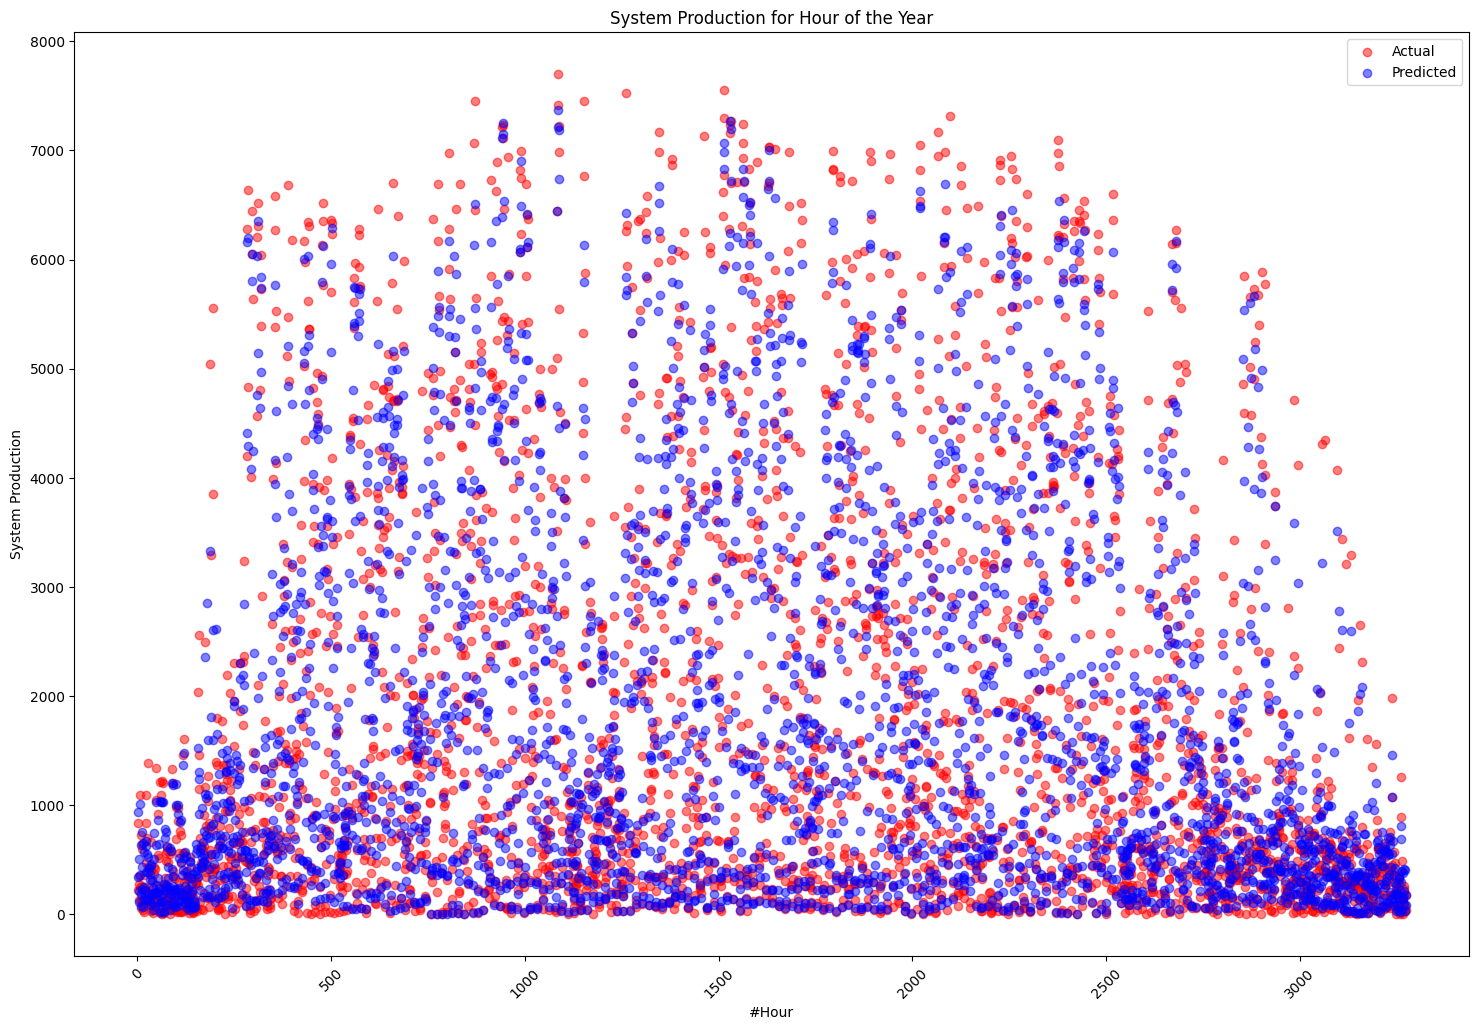

In [22]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(18, 12))
# Create a scatter plot
#plt.plot(dates, y)
x_real = list(range(1, data[['Month', 'Day', 'Hour']].shape[0]+1))
y_pred = model.predict(scaler.transform(data[['Month', 'Day', 'Hour']]))

plt.scatter(x_real, data['SystemProduction'], color='red', alpha=0.5)
plt.scatter(x_real, y_pred, color='blue', alpha=0.5)
# Set the labels and title
plt.xlabel('#Hour')
plt.ylabel('System Production')
plt.title('System Production for Hour of the Year')
plt.legend(['Actual', 'Predicted'])
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()


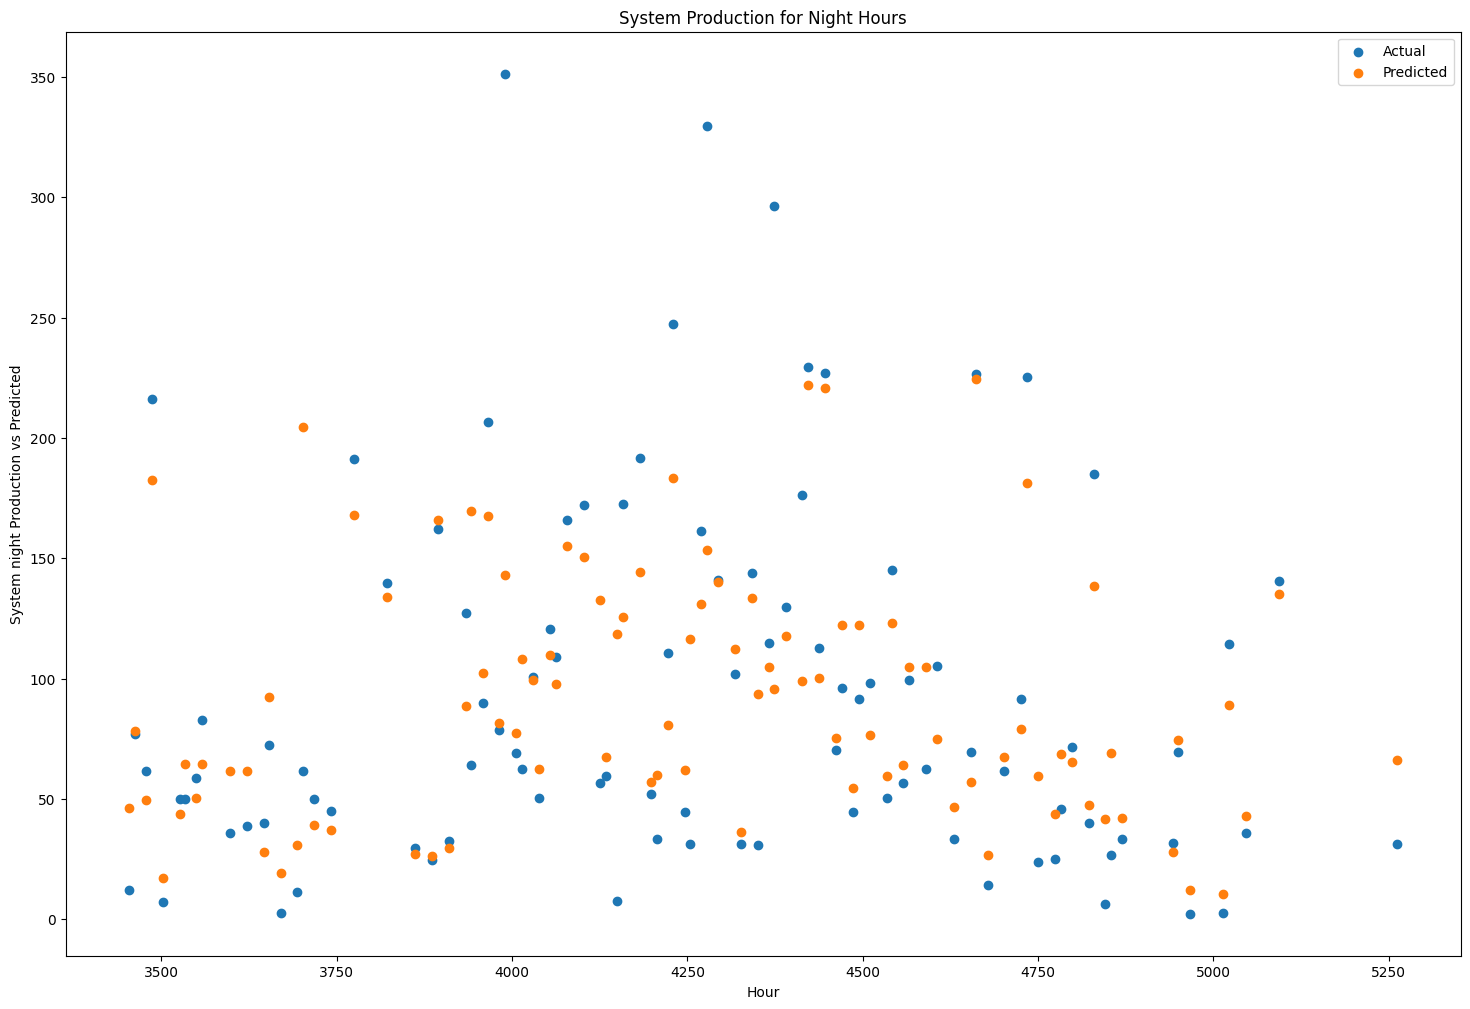

Mean Squared Error: 2288.09
R^2 Score: 0.58


In [14]:
# Evaluate night time predictions
night_data = data[data['Hour'].isin([0, 1, 2, 3, 4, 5, 6, 22, 23])]
pred_night_data = model.predict(scaler.transform(night_data[['Month', 'Day', 'Hour']]))
mse = mean_squared_error(night_data['SystemProduction'], pred_night_data)
r2 = r2_score(night_data['SystemProduction'], pred_night_data)

# Plot the actual vs predicted night values
plt.figure(figsize=(18, 12))
plt.scatter(x=night_data.index, y=night_data['SystemProduction'])
plt.scatter(x=night_data.index, y=pred_night_data)
plt.xlabel('Hour')
plt.ylabel('System night Production vs Predicted')
plt.title('System Production for Night Hours')
plt.legend(['Actual', 'Predicted'])
plt.show() 

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

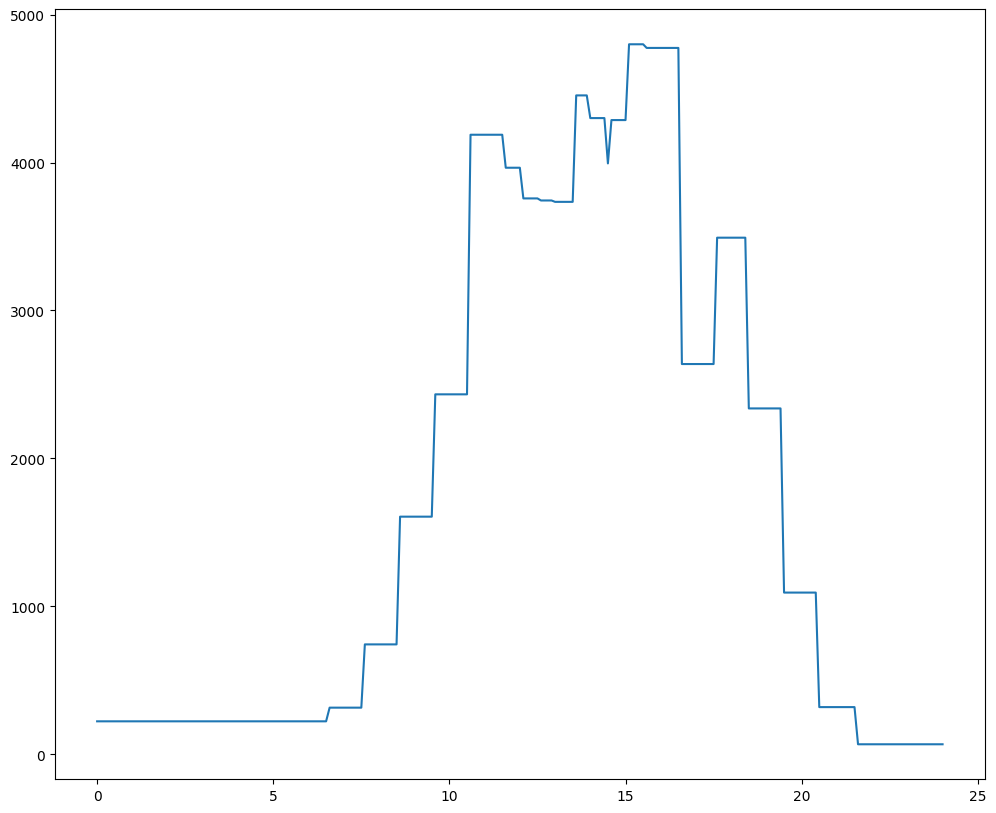

In [16]:
#Seeing the accurancy of the model in the order of minutes
x_month = [7.0] * 241
x_day = [15.0] * 241
hours = range(24)
plt.figure(figsize=(12, 10))
x_hours = [float(hour) for hour in range(0, 241, 1)]
x_hours = [hour / 10 for hour in x_hours]
x = pd.DataFrame({'Month': x_month, 'Day': x_day, 'Hour': x_hours})
data = x[['Month', 'Day', 'Hour']]
y = model.predict(scaler.transform(data))
plt.plot(x_hours, y)

In [37]:
import emlearn

#Convert the model to C code for use in IoT devices
path = './solar_prediction.h'
cmodel = emlearn.convert(model, method='inline')
cmodel.save(file=path, name='solar_prediction')

print('Wrote model to', path)

Wrote model to ./solar_prediction.h
